## 3.1. 워크플로

### 3.1.1. 데이터 준비

In [1]:
using Downloads, CSV, DataFrames
url = "https://datahub.io/machine-learning/iris/r/iris.csv";
iris = CSV.read(Downloads.download(url), DataFrame)

Row,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


데이터셋 분할

In [2]:
using MLJ
iris.class = coerce(iris.class, Multiclass)

iris_train, iris_test = partition(iris, 0.7, rng=0)

y_train, X_train = unpack(iris_train, ==(:class));
y_test, X_test = unpack(iris_test, ==(:class));

X_train[1:3,:]

Row,sepallength,sepalwidth,petallength,petalwidth
,Float64,Float64,Float64,Float64
1,6.9,3.2,5.7,2.3
2,5.8,2.7,5.1,1.9
3,6.6,2.9,4.6,1.3


### 3.1.2. 모델 준비

모델 검색

In [3]:
models(matching(X_train, y_train))

48-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = B

모델 코드 로딩

In [4]:
Tree = @load DecisionTreeClassifier pkg=DecisionTree
tree = Tree(rng=0)
tree.max_depth = 2;

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/tyfun/.julia/packages/MLJModels/8Nrhi/src/loading.jl:159


import MLJDecisionTreeInterface ✔


### 3.1.3. 학습 / 예측 / 평가

학습

In [5]:
mach = machine(tree, X_train, y_train)
fit!(mach);

┌ Info: Training machine(DecisionTreeClassifier(max_depth = 2, …), …).
└ @ MLJBase /home/tyfun/.julia/packages/MLJBase/uxwHr/src/machines.jl:492


In [6]:
mach.report[:fit].print_tree()

Feature 4 < 0.7 ?
├─ 1 : 30/30
└─ Feature 3 < 4.75 ?
    ├─ 2 : 29/30
    └─ 3 : 42/45


In [7]:
fitted = fitted_params(mach)
fitted.encoding, fitted.features

(Dict{UInt32, CategoricalArrays.CategoricalValue{String15, UInt32}}(0x00000002 => String15("Iris-versicolor"), 0x00000003 => String15("Iris-virginica"), 0x00000001 => String15("Iris-setosa")), [:sepallength, :sepalwidth, :petallength, :petalwidth])

In [8]:
using Query
@from r in iris_train begin
    @where r.petalwidth >= 0.7 && r.petallength >= 4.75
    @group r by r.class into g
    @select { class = key(g), nrow = length(g) }
    @collect DataFrame
end

Row,class,nrow
,Cat…,Int64
1,Iris-virginica,42
2,Iris-versicolor,3


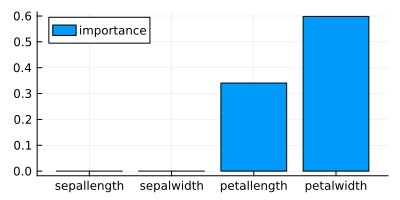

In [9]:
import DecisionTree
feat_imps = DecisionTree.impurity_importance(fitted.tree)
using Plots
gr(size=(400,200))
bar(string.(fitted.features), feat_imps, label="importance")

예측

In [10]:
pred = predict(mach, X_test);
pred_mode = predict_mode(mach, X_test)

45-element CategoricalArrays.CategoricalArray{String15,1,UInt32}:
 String15("Iris-virginica")
 String15("Iris-versicolor")
 String15("Iris-setosa")
 String15("Iris-versicolor")
 String15("Iris-setosa")
 String15("Iris-versicolor")
 String15("Iris-setosa")
 String15("Iris-versicolor")
 String15("Iris-setosa")
 String15("Iris-virginica")
 ⋮
 String15("Iris-virginica")
 String15("Iris-versicolor")
 String15("Iris-setosa")
 String15("Iris-setosa")
 String15("Iris-setosa")
 String15("Iris-virginica")
 String15("Iris-versicolor")
 String15("Iris-versicolor")
 String15("Iris-versicolor")

평가 측도

In [11]:
println("log loss : ", log_loss(pred, y_test) |> mean)
println("accuracy : ", accuracy(pred_mode, y_test))
println("macro f1 : ", macro_f1score(String.(pred_mode), String.(y_test)))

log loss : 0.20256942175223366
accuracy : 

0.9333333333333333


macro f1 : 0.9108734402852049


교차 검증

In [12]:
y, X = unpack(iris, ==(:class));
cv = CV(nfolds=3, shuffle=true, rng=0);
measures = [log_loss, accuracy];
evaluate(tree, X, y, resampling=cv, measures=measures)

Evaluating over 3 folds:  67%[================>        ]  ETA: 0:00:01

Evaluating over 3 folds: 100%[=========================] Time: 0:00:01


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────┬──────────────┬─────────────┬─────────┬───────
│ measure                        │ operation    │ measurement │ 1.96*SE │ per_ ⋯
├────────────────────────────────┼──────────────┼─────────────┼─────────┼───────
│ LogLoss(                       │ predict      │ 0.638       │ 0.548   │ [0.8 ⋯
│   tol = 2.220446049250313e-16) │              │             │         │      ⋯
│ Accuracy()                     │ predict_mode │ 0.94        │ N/A     │ [0.9 ⋯
└────────────────────────────────┴──────────────┴─────────────┴─────────┴───────
                                                                1 column omitted


### 3.1.4. 하이퍼 파라미터 튜닝

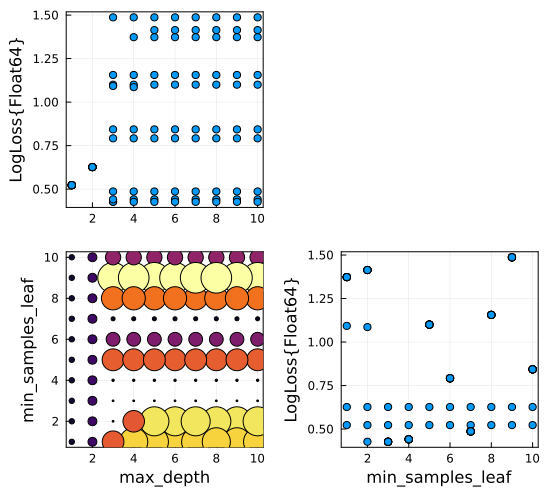

In [19]:
tree = Tree(rng=10)
depth_range = range(tree, :max_depth, lower = 1, upper = 10);
sample_range = range(tree, :min_samples_leaf, lower = 1, upper = 10);
grid_tree = TunedModel(tree, 
    resampling = CV(nfolds=5, rng=10), 
    tuning = Grid(resolution=10), 
    range = [depth_range, sample_range],
    measure = log_loss);

grid_mach = machine(grid_tree, X_train, y_train);
fit!(grid_mach, verbosity=0);
plot(grid_mach)

In [14]:
fitted_params(grid_mach).best_model

DecisionTreeClassifier(
  max_depth = 4, 
  min_samples_leaf = 3, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = 10)

In [15]:
report(grid_mach).best_report.print_tree()

Feature 4 < 0.7 ?
├─ 1 : 30/30
└─ Feature 3 < 4.75 ?
    ├─ Feature 1 < 5.05 ?
        ├─ 2 : 3/4
        └─ 2 : 26/26
    └─ Feature 3 < 4.95 ?
        ├─ Feature 1 < 6.25 ?
            ├─ 3 : 4/5
            └─ 2 : 2/3
        └─ 3 : 37/37


In [16]:
pred_mode = predict_mode(grid_mach, X_test);
accuracy(pred_mode, y_test)

0.9555555555555556

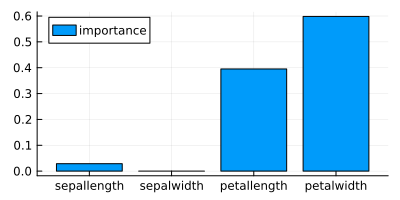

In [21]:
fitted = fitted_params(grid_mach).best_fitted_params
feat_imps = DecisionTree.impurity_importance(fitted.tree)
gr(size=(400,200))
bar(string.(fitted.features), feat_imps, label="importance")

조기 종료

In [22]:

purity_range = range(tree, :min_purity_increase, lower = 0, upper = 0.1);
grid_tree = TunedModel(tree, 
    resampling = CV(nfolds=5, rng=10), 
    tuning = Grid(resolution=10), 
    range = [depth_range, sample_range, purity_range],
    measure = log_loss);
# early stopping
iterated_tree = IteratedModel(model=grid_tree,
                               resampling=nothing,
                               control=[Step(1), NumberSinceBest(100), Patience(10), NumberLimit(300)],
                               measure=log_loss,
                               retrain=true);
iter_mach = machine(iterated_tree, X_train, y_train);
fit!(iter_mach, verbosity=0);
pred_mode = predict_mode(iter_mach, X_test);
accuracy(pred_mode, y_test)

0.9555555555555556